# Simple N-body system

Below a simple gravitational N-body system is solved. Using dimensionless variables the problem is described with the following two equations

$$\frac{d\vec{x}_i}{dt} = \vec{v}_i\\\frac{d\vec{v}_i}{dt}=\sum_{k\neq i}m_k\frac{\vec{x}_k-\vec{x_i}}{|\vec{x}_k-\vec{x_i}|^3}$$  


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Calculate the acceleration
#
# s: Matrix of dimension Nx3
# m: Vector of all masses

def acc(s, m):

    acceleration = np.zeros(s.shape)
    
    for i in range(len(s[:,0])):
        for j in range(len(s[:,0])):
            if i is not j:
                acceleration[i,:] += m[j] * (s[j,:] - s[i,:]) / (np.dot(s[j,:] - s[i,:], s[j,:] - s[i,:])**(3/2))
                
    return acceleration

In [3]:
## Function to check if two bodies get close to each other
#
# s:     Matrix of the current position of all bodies. Dimensions Nx3
# limit: Threshold for close encounter

def closeEncounter(s, limit):

    for i in range(len(s[:,0])):
        for j in range(len(s[:,0])):
            if i != j:
                distance = np.sqrt(np.dot(s[j,:] - s[i,:], s[j,:] - s[i,:]))
                if distance < limit:
                    return True
    return False
        
    

In [4]:
## One step of the leap frog algorithm
#
# f:        Function to calculate the acceleration
# currentS: Matrix of dimension Nx3
# currentW: Matrix of dimension Nx3 
# m:        Vector of all masses
# dt:       Timestep

def leapFrogStep(f, currentS, currentW, m, dt):
    
    wPlusHalf = currentW + 0.5 * f(currentS, m) * dt   # Kick
    sPlusOne = currentS + wPlusHalf * dt               # Drift
    wPlusOne = wPlusHalf + 0.5 * f(sPlusOne, m) * dt   # Kick
    
    return sPlusOne, wPlusOne

In [49]:
## Performe the leap frog integration
#
# f:         Function to calculate the acceleration
# s0:        Initial conditions for the positions. Matrix of dimension Nx3
# w0:        Initial conditions for the velocities. Matrix of dimension Nx3
# numBodies: Number of bodies in the system.
# nimIt:     Number of simulation steps to compute.
# m:         Vector of all masses.
# closeEncounterCheck: Cloe encounter check used in the last section
#
# return:    Return tensor of dimension (numItxNx3) for the positions and velosities.

def leapFrog(f, s0, v0, dt, numBodies, numIt, m, closeEncounterCheck=False, limit=0.001):
    
    resultS = np.zeros([numIt, numBodies, 3])
    resultW = np.zeros([numIt, numBodies, 3])
    
    resultS[0] = s0 
    resultW[0] = v0
    
    slowDown = False
    
    for i in range(1, numIt):
        
        if closeEncounterCheck:
            check = closeEncounter(resultS[i-1], limit)
            if check and not slowDown:
                dt /= 10.0
                slowDown = True
            elif not check and slowDown:
                dt *= 10.0
                slowDown = False
        
        resultS[i], resultW[i] = leapFrogStep(f, resultS[i-1], resultW[i-1], m, dt)
    
    return resultS, resultW

In [43]:
## Plot the trajectories of all bodies.
#
# s:         Tensor of dimension (numItxNx3) for all trajectories
# numBodies: Number of bodies in the system
# xlim:      Range of x-axis of the plot
# ylim:      Range of y-axis of the plot
# clipAxis:  Bool to activate xlim and ylim

def plot_n_body(axs, title, s, numBodies, clipAxis = False, xlim = [0.0], ylim = [0,0]):
    
    for i in range(numBodies):
        sx = s[:,i,0]
        sy = s[:,i,1]
        axs.plot(sx, sy)
        
    if clipAxis:
        axs.set_xlim(xlim)
        axs.set_ylim(ylim)
    axs.set_title(title)
    return axs

## Testing with a binary star system

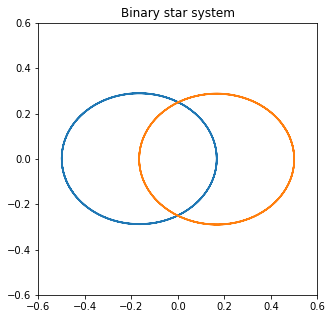

In [34]:
# Initial conditions of for the binary star system
s_init = np.array([[-0.5,0,0],[0.5, 0, 0]])
v_init = np.array([[0,-0.5,0], [0, 0.5, 0]])
m = np.array([1, 1])

numBodies = 2
dt = 0.01
numSteps = int(10 / dt)

resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs = plot_n_body(axs, "Binary star system", resultS, numBodies, True, [-0.6, 0.6], [-0.6, 0.6])
plt.show()

## Adding a third star to the binary system

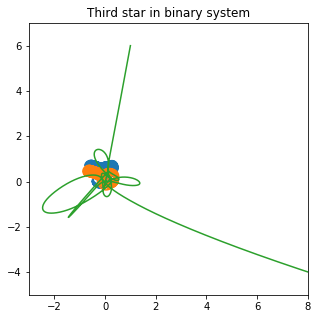

In [35]:
s_init = np.array([[-0.5,0,0],[0.5, 0, 0],[1,6,2]])
v_init = np.array([[0,-0.5,0], [0, 0.5, 0],[0,0,0]])
m = np.array([1, 1, 0.1])

numBodies = 3
dt = 0.01
numSteps = int(75 / dt)

resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs = plot_n_body(axs, "Third star in binary system", resultS, numBodies, True, [-3, 8], [-5, 7])
plt.show()

The trajectory above shows how the thrid star (green) falls into the binary system and interacts with it.  
After some time the third star is then ejected from the binary system (trajectory leaving the plot in the right bottom corner).

### Playing with the time step
Now we will play with the time step while leaving the overall simulation time the same and observe how this effects the trajectories.

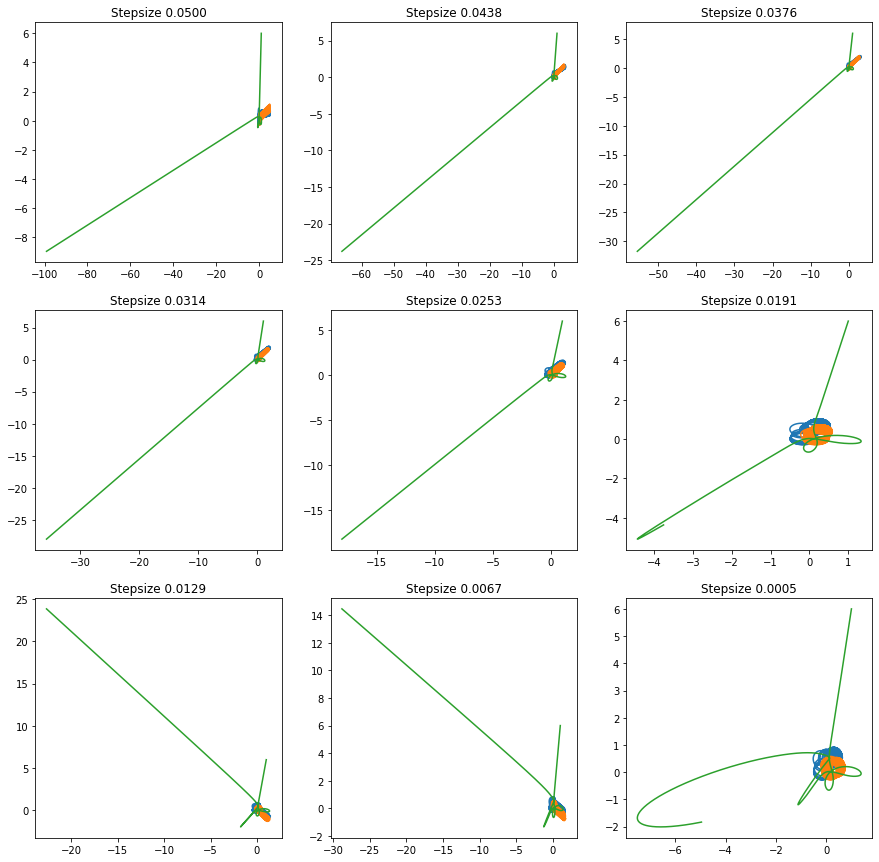

In [36]:
numBodies = 3
dt = 0.01

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
i = 0
j= 0
for dt in np.linspace(0.05, 0.0005, num=9):
    numSteps = int(75 / dt)
    resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m)
    plot_n_body(axs[j][i], "Stepsize {0:.4f}".format(dt), resultS, numBodies, False, [-1, 1], [-1, 1])
    i += 1
    if i == 3:
        i = 0
        j += 1
    
plt.show()

As can be seen in the figures above decreasing the time step leads to the third body staying in the system longer.

## Simulating a N-body system with N bigger then 3.

In this section 30 random bodies will be simulated. The same simulation will be run for different random seeds.

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


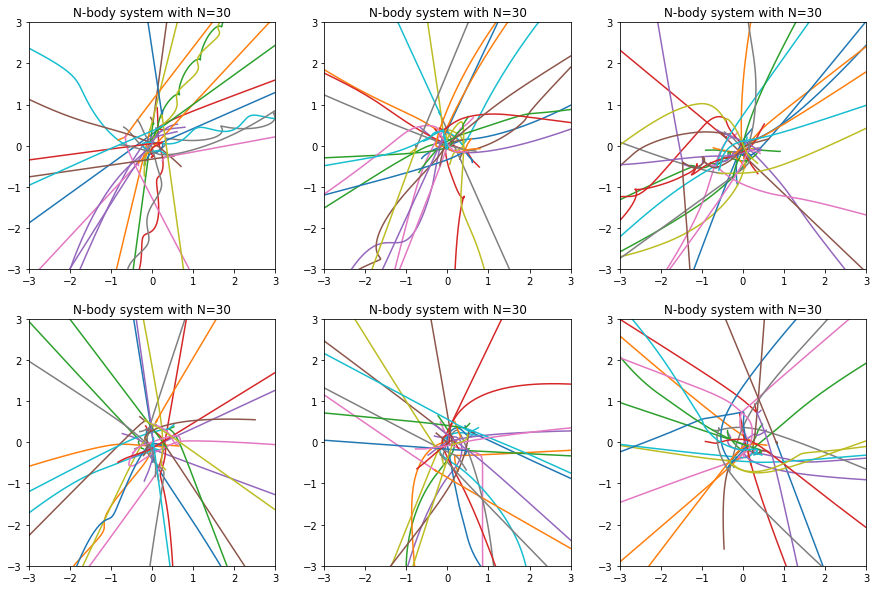

In [37]:
# Get a random point in the unitsphere
def getPoint():
        
    while True:
        a = np.random.uniform(-1, 1, 3)

        if(np.dot(a, a)**(1/2) <= 1):
            return a

# Get a random relocity with |v| <= 0.1
def getVelocity():
        
    while True:
        a = np.random.uniform(-1, 1, 3)

        if(np.dot(a, a)**(1/2) <= 0.1):
            return a


dt = 0.01
numBodies = 30
numSteps = int(5/dt)

# Initial calues
m = np.ones(numBodies)
s_init = np.zeros([numBodies, 3])
v_init = np.zeros([numBodies, 3])

        

    
    
resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
i = 0
j= 0
for k in range(6):
    
    # Initialize the 30 random stars
    np.random.seed(k)
    for l in range(numBodies):
        s_init[l,:] = getPoint()
        v_init[l,:] = getVelocity()
    
    resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m)
    plot_n_body(axs[j][i], "N-body system with N=30", resultS, numBodies, True, [-3, 3], [-3, 3])
    i += 1
    if i == 3:
        i = 0
        j += 1
    
plt.show()

### Run the simulation with N=300
Increasing the number of bodies from 30 to 300 increases the execution time by a factor of 100 because the complexity of the problem is $O(n^2)$.

In [38]:
dt = 0.01
numBodies = 50
numSteps = int(5/dt)

# Initial calues
m = np.ones(numBodies)/10.0
s_init = np.zeros([numBodies, 3])
v_init = np.zeros([numBodies, 3])


# Initialize the 300 random stars
for i in range(numBodies):
    s_init[i,:] = getPoint()
    v_init[i,:] = getVelocity()
    

    
#resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m)
    

In [39]:
# Plot the result
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs = plot_n_body(axs, "N-body system with N=300", resultS, numBodies, True, [-3, 3], [-3, 3])
plt.show()
"""

'\nfig, axs = plt.subplots(1, 1, figsize=(5, 5))\naxs = plot_n_body(axs, "N-body system with N=300", resultS, numBodies, True, [-3, 3], [-3, 3])\nplt.show()\n'

## Close encounter checker
Now a close encounter checker will be added to the simulation to decrease the time step whenever
two bodies get clos to each other. This should lead to a more exact simulation.

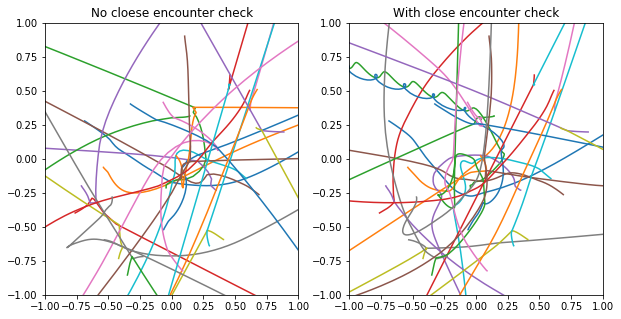

In [56]:
dt = 0.01
numBodies = 30
numSteps = int(20/dt)


# Initial calues
m = np.ones(numBodies)
s_init = np.zeros([numBodies, 3])
v_init = np.zeros([numBodies, 3])


# Initialize the 30 random stars
for i in range(numBodies):
    s_init[i,:] = getPoint()
    v_init[i,:] = getVelocity()
    

    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m, False)
axs[0] = plot_n_body(axs[0], "No cloese encounter check", resultS, numBodies, True, [-1, 1], [-1, 1])

resultS, resultV = leapFrog(acc, s_init, v_init, dt, numBodies, numSteps, m, True, 0.1)
axs[1] = plot_n_body(axs[1], "With close encounter check", resultS, numBodies, True, [-1, 1], [-1, 1])
plt.show()

As we can see in the figures above using a close encounter check with a decreasing of the time step by a factor 10
results in a better simulation of the bodies close to each other.